[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/nathanielnyema/meal-patterns/blob/main/meal_patterns.ipynb)

In [1]:
#@title notebook setup
!pip install xlsxwriter xlrd>2.0

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import datetime
from datetime import timedelta
import matplotlib.dates as mdates
from pathlib import Path
import csv
import os
import sys
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')
    if not os.path.exists("meal-patterns"):
        !git clone https://github.com/nathanielnyema/meal-patterns
    sys.path.append("meal-patterns")
from meal_patterns import *

In [2]:
# @title settings
#@markdown The path to the data file
fpath = "test run.xlsx" #@param {type: "string"}
#@markdown The minimum time in minutes between meals
inter_thresh = 5 #@param {type: "number"}
#@markdown An exclusion criteria for the data. Events with gram amounts below this value will be excluded
excl = 0.02 #@param {type: "number"}
#@markdown The bin size in hours
binsize_hr = 1 #@param {type: "number"}
#@markdown The desired start time of the first bin in the analysis (in military time). If these values are both set to 0 the timestamp of the earliest event will be used instead.
start_hr =   10#@param {type: "number"}
start_min = 0 #@param {type: "number"}
start = None if start_hr + start_min ==0 else datetime.time(start_hr, start_min)
#@markdown The names of the sheets in the excel file with the feeder data. Any empty fields will be ignored
sheets_a = "FoodA_Intake_Pattern" #@param{type: "string"}
sheets_b = "FoodB_Intake_Pattern" #@param{type: "string"}
sheets_c = "" #@param{type: "string"}
sheets_d = "" #@param{type: "string"}
sheets = [sheets_a, sheets_b, sheets_c, sheets_d]
sheets = [i for i in sheets if len(i)>0]
#@markdown Was this data collected with the labmaster?
labmaster = False #@param{type: "boolean"}

#############################################################################################################
fpath = Path(fpath).resolve()
fname = f"{fpath.stem}_{inter_thresh}min_thresh_{start if start else 'unspec'}_start_{binsize_hr}hr_bins.xlsx"
df = load_data(fpath, sheets, labmaster)
start = start = df.start_dts.min() if start is None else datetime.datetime.combine(df.start_dts.min().date(), start)
bout_stats, binned_stats = run_analysis(df, inter_thresh = inter_thresh, 
                                        excl = excl, binsize_hr = binsize_hr,
                                        start = start, fname = fname)
stats = ['dur_s', 'size', 'imis_s', 'meal_n']
    
#write the results to an excel spreadsheet
with pd.ExcelWriter(fname, engine='xlsxwriter') as writer:
    for stat in stats:
        binned_stats.unstack(['feeder','Cage'])[stat].to_excel(writer, sheet_name = stat)
    
end = df.end_dts.max()
ts = pd.date_range(start, end, 1000)
night = (ts.time>datetime.time(19) )| (ts.time<datetime.time(7))

In [62]:
bout_stats.head(10)

start                 end  \
feeder               Cage bout_n                                           
FoodA_Intake_Pattern 1    0.0    2022-04-28 13:26:21 2022-04-28 13:27:14   
                          1.0    2022-04-28 17:05:16 2022-04-28 17:05:54   
                          2.0    2022-04-28 17:18:12 2022-04-28 17:22:06   
                          3.0    2022-04-28 19:18:39 2022-04-28 19:29:56   
                          4.0    2022-04-28 19:42:42 2022-04-28 19:49:08   
                          5.0    2022-04-28 20:21:41 2022-04-28 20:28:52   
                          6.0    2022-04-28 20:43:42 2022-04-28 20:54:10   
                          7.0    2022-04-28 21:06:56 2022-04-28 21:15:45   
                          8.0    2022-04-28 21:30:16 2022-04-28 21:39:27   
                          9.0    2022-04-28 22:14:41 2022-04-28 22:24:42   

                                  dur_s   size     imis                bins  
feeder               Cage bout_n                                             
FoodA_Intake_Pattern 1    0.0      53.0  0.449      NaN 2022-04-28 13:00:00  
                          1.0      38.0  0.036  13082.0 2022-04-28 17:00:00  
                          2.0     234.0  0.498    738.0 2022-04-28 17:00:00  
                          3.0     677.0  0.188   6993.0 2022-04-28 19:00:00  
                          4.0     386.0  0.071    766.0 2022-04-28 19:00:00  
                          5.0     431.0  0.072   1953.0 2022-04-28 20:00:00  
                          6.0     628.0  0.124    890.0 2022-04-28 20:00:00  
                          7.0     529.0  0.105    766.0 2022-04-28 21:00:00  
                          8.0     551.0  0.101    871.0 2022-04-28 21:00:00  
                          9.0     601.0  0.118   2114.0 2022-04-28 22:00:00

In [63]:
binned_stats.head(10)

dur_s    imis   size  meal_n
feeder               Cage bins                                             
FoodA_Intake_Pattern 1    2022-04-28 10:00:00    0.0     0.0  0.000     0.0
                     2    2022-04-28 10:00:00   19.0     0.0  0.023     1.0
                     3    2022-04-28 10:00:00    0.0     0.0  0.000     0.0
                     4    2022-04-28 10:00:00    0.0     0.0  0.000     0.0
                     5    2022-04-28 10:00:00    0.0     0.0  0.000     0.0
                     6    2022-04-28 10:00:00  408.0     0.0  0.102     1.0
                     7    2022-04-28 10:00:00  106.0     0.0  0.042     2.0
                     8    2022-04-28 10:00:00  396.0   535.0  0.097     2.0
                     1    2022-04-28 11:00:00    0.0     0.0  0.000     0.0
                     2    2022-04-28 11:00:00   97.5  2284.5  4.533     2.0

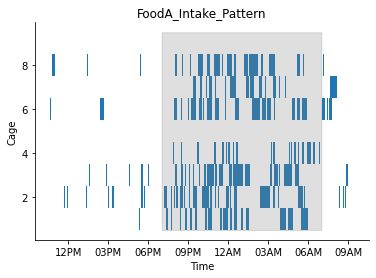

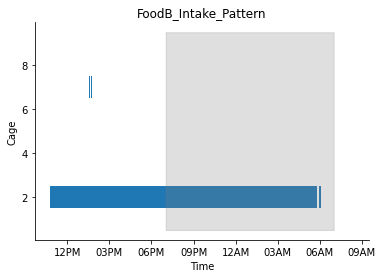

In [74]:
#@title view eventplots of the data
for s in sheets:
    _,ax = plt.subplots(1,1)
    for i in bout_stats.index.get_level_values('Cage').unique():
        try:
            ax.broken_barh(list(zip(bout_stats.loc[s,i]['start'],
                                     timedelta(seconds=1) * bout_stats.loc[s,i]['dur_s'])), (float(i)-.5,1))
        except:
            pass
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%I%p'))
    ts = pd.date_range(start, end, 1000)
    night = (ts.time>datetime.time(19) )| (ts.time<datetime.time(7))
    ax.fill_between(ts, .5, 9.5, where = night, color = 'gray', alpha = 0.25)
    sns.despine()
    ax.set_ylabel('Cage');
    ax.set_xlabel('Time');
    ax.set_title(s)

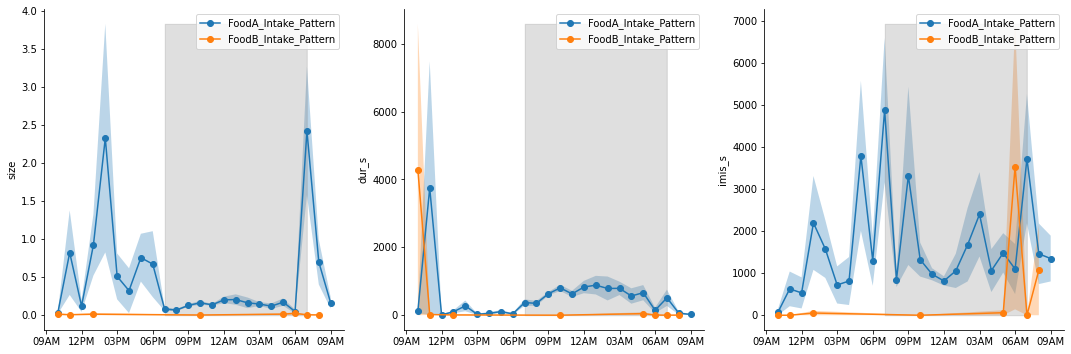

In [75]:
#@title plot the binned data
#NOTE: I'm plotting mean +/- sem here but i'm not sure the mean is the best representation of the data
# especially for imi where the values are sparse

fig,ax = plt.subplots(1,3, figsize = (15,5))
stats = [ 'size','dur_s', 'imis_s']

for i,stat in enumerate(stats):
    sems = binned_stats.fillna(0).groupby(['feeder','bins']).sem()
    mns =binned_stats.fillna(0).groupby(['feeder','bins']).mean()
    for s in sheets:
        ax[i].plot(sems.loc[s].index, mns.loc[s][stat], marker = 'o', label = s)
        ax[i].fill_between(sems.loc[s].index, mns.loc[s][stat] - sems.loc[s][stat], 
                           mns.loc[s][stat] + sems.loc[s][stat], alpha=0.3, )
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%I%p'))
    ax[i].fill_between(ts, (mns - sems)[stat].min(), (mns + sems)[stat].max(), 
                       where = night, color = 'gray', alpha = 0.25)
    ax[i].legend()
    ax[i].set_ylabel(stat)

sns.despine()
fig.tight_layout(pad = 1.)

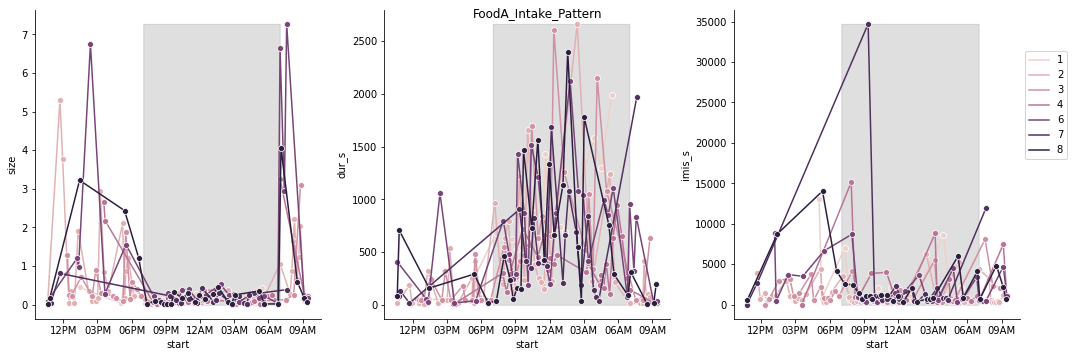

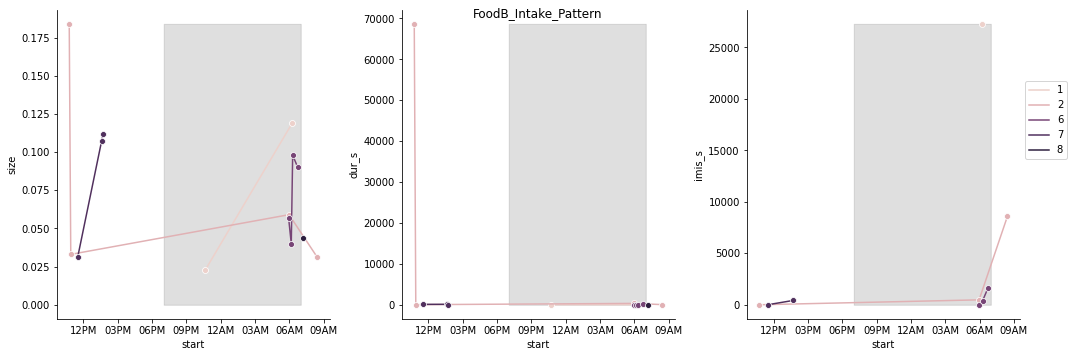

In [78]:
#@title plot bout statistics for individual mice
for s in sheets:
    fig,ax = plt.subplots(1,3, figsize = (15,5))
    sns.lineplot(data = bout_stats.loc[s].reset_index(), x = 'start', y='size', hue = 'Cage', marker = 'o', legend=False, ax = ax[0])
    ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%I%p'))
    ax[0].fill_between(ts, 0, bout_stats.loc[s]['size'].max(), where = night, color = 'gray', alpha = 0.25)

    sns.lineplot(data = bout_stats.loc[s].reset_index(), x = 'start', y='dur_s', hue = 'Cage', marker = 'o',legend=False,  ax = ax[1])
    ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%I%p'))
    ax[1].fill_between(ts, 0, bout_stats.loc[s].dur_s.max(), where = night, color = 'gray', alpha = 0.25)

    g = sns.lineplot(data = bout_stats.loc[s].reset_index(), x = 'start', y='imis_s', hue = 'Cage', marker = 'o',  legend='full', ax = ax[2])
    g.legend(loc='lower left', bbox_to_anchor=(1, 0.5))
    ax[2].xaxis.set_major_formatter(mdates.DateFormatter('%I%p'))
    ax[2].fill_between(ts, 0, bout_stats.loc[s].imis_s.max(), where = night, color = 'gray', alpha = 0.25)

    sns.despine()
    fig.suptitle(s)
    fig.tight_layout(pad=1.)